# Assessing quality of CO functionalized tips

In [ ]:
import os
import glob
import numpy as np
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import cm
from utils import *
%matplotlib inline

## Upload AFM data with bad and good samples of CO-tips
Download AFM-data with CO-tips samples from here: https://www.dropbox.com/s/wqhgbvdlfb6snic/datasetNew6.tar.gz?dl=0. Extract the archive and set the path of the directory to the variable path_to_data below.

In [30]:
path_to_data = './databaseNew6'

## PCA *analysis* 

In [39]:
# Here we generate dataset for PCA and t-SNE analysis. All available images without augumentation are used (enable_rotations = False).

save_dir         = './PCA3/'
classes          = ['bads', 'goods']
crop_size        = 16    # different size images would be transformed to size 32 x 32
enable_rotations = False # no augumentation by rotations for PCA analysis
enable_flips = False
if os.path.exists(save_dir+'dataset_pca.npz'): 
    # if dataset was generated before, just load it
    print ('dataset founded')
    try:    
        data= np.load(save_dir+'dataset_pca.npz')
        trainX=data['trainX']
        trainY=data['trainY']
        valX=data['valX']
        valY=data['valY']
        testX=data['testX']
        testY=data['testY']
        print (f'trainY: {len(trainY)}')    
        print (f'valY: {len(valY)}')    
        print (f'testY: {len(testY)}')    
        print ('dataset loaded succesfully')
    except KeyError as e:
        print('Could not find filename %s' % e)
else:  
    #no dataset founded, we generate new one and save it
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    # train data
    print('gen training data') 
    trainX, trainY = generate_data_from_images(path_to_data, 'train', classes,crop_size, enable_rotations, enable_flips)
    print (f'trainX: {trainX.shape}')
    print (f'trainY: {trainY.shape}')

    # validation data
    print('gen validation data')  
    valX, valY     = generate_data_from_images(path_to_data, 'valid', classes,crop_size, enable_rotations, enable_flips)
    print (f'valX: {valX.shape}')
    print (f'valY: {valY.shape}')

    # test data
    print('gen test data')  
    testX, testY   = generate_data_from_images(path_to_data, 'test2', classes,crop_size, enable_rotations, enable_flips) 
    print (f'testX: {testX.shape}')
    print (f'testY: {testY.shape}')
    
    # save whole PCA dataset
    file_dataset = 'dataset_pca.npz'
    np.savez(save_dir+ file_dataset , trainX=trainX,trainY=trainY, valX = valX, valY = valY, testX =testX, testY =testY  )
    print (f'dataset saved succesfully to {save_dir+ file_dataset}')


dataset founded
trainY: 204
valY: 69
testY: 73
dataset loaded succesfully


### Dataset statistic

[[ 83 121]
 [ 25  44]
 [ 36  37]]


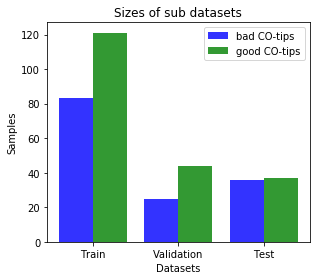

In [40]:
# plot dataset sizes
import pandas as pd
count_tips= []
for tip_quality in [trainY, valY,testY]:
    count_tips.append([sum(tip_quality == 0),sum(tip_quality == 1)])
count_tips = np.array(count_tips, dtype=np.int32)
print(count_tips)

n_sets = 3
# create plot
fig = plt.figure(figsize=(4.5,4))
index = np.arange(n_sets)
bar_width = 0.4
opacity = 0.8
rects1 = plt.bar(index, count_tips[:,0], bar_width, alpha=opacity, color='b', label='bad CO-tips')
rects2 = plt.bar(index + bar_width, count_tips[:,1], bar_width,alpha=opacity, color='g', label='good CO-tips')

plt.ylabel('Samples')
plt.xlabel('Datasets')
plt.title('Sizes of sub datasets')
plt.xticks(index + bar_width/2, ('Train', 'Validation', 'Test'))
plt.legend()

plt.tight_layout()
plt.savefig('dataset_statistic.png', bbox_inches='tight', dpi=200)
plt.show()
plt.close()

In [ ]:
def make_set_plots(path_to_data, set_name, outdir, classes,crop_size, enable_rotations, enable_flips):

    dataX = []
    dataY = []
    file_names = []
    z = len(classes)
    if (enable_rotations):
        amount_rot = 4
    else:
        amount_rot = 1

    for class_ind, cls in enumerate(classes):

        images = sorted(glob.glob(path_to_data+'/'+set_name+'/'+cls + '/' +'*.png'))
        for image_path in images:
            _, file_name = os.path.split(image_path)
            file_name = file_name[:-4]
            #image = np.array((Image.open(image_path).resize((crop_size,crop_size), Image.ANTIALIAS))).astype(np.float32)
            image = np.array(Image.open(image_path)).astype(np.float32)
            #print (image.shape) 
            for rotations in range(amount_rot): 
                    rot_image = np.rot90(image,rotations, axes=(-2,-1))             
                    dataX.append(rot_image)
                    dataY.append(class_ind)
                    file_names.append(file_name)
                    if (enable_flips):
                        dataX.append(np.flipud(rot_image))
                        dataY.append(class_ind)
                        file_names.append(file_name)
                        
                        #dataX.append(np.fliplr(rot_image))
                        #dataY.append(class_ind)
                        #file_names.append(file_name)
           
        
        
    cmap=cm.gray
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    img_ind = 0
     
    cols = 10
    rows = -(-len(file_names) // cols) 
    #rows = 4
    #permut = np.array( range(X.shape[0]) )
    #np.random.shuffle( permut )
    txt_colors = ['red','green']
    fig = plt.figure(figsize=(3*cols,3*rows))
    permut = np.random.permutation(len(file_names))
    for i in range(len(file_names)):
    #for i in range(40):

        sp = fig.add_subplot(rows,cols,img_ind+1)#, origin="lower"
        sp.imshow(dataX[img_ind], cmap = cmap)   
        sp.axis('Off')
        sp.set_title(f'{classes[dataY[img_ind]]}: {file_names[img_ind]}', color =txt_colors[dataY[img_ind]]) 

        if (img_ind > len(dataX)-2):
            break
        else:
            img_ind+=1
    save_name = f'{outdir}database_{set_name}_big.png'
    plt.savefig(save_name, bbox_inches="tight")
    plt.close()
    print('Input image saved to '+save_name)
        
            
 
        
enable_rotations = False
enable_flips = False
outdir = save_dir
classes          = ['bads', 'goods']
make_set_plots(path_to_data, 'train',outdir, classes,crop_size, enable_rotations, enable_flips)
make_set_plots(path_to_data, 'valid',outdir, classes,crop_size, enable_rotations, enable_flips)
make_set_plots(path_to_data, 'test2',outdir, classes,crop_size, enable_rotations, enable_flips)

In [ ]:
def make_class_sets_plots(path_to_data, set_names, classes,class_ind, outdir,crop_size, enable_rotations, enable_flips):

    dataX = []
    dataY = []
    file_names = []
    z = len(classes)
    if (enable_rotations):
        amount_rot = 4
    else:
        amount_rot = 1
    for set_name in set_names:
        cls = classes[class_ind]
        print (f'set_name = {set_name}')
        print (f'cls = {cls}')
        images = sorted(glob.glob(path_to_data+'/'+set_name+'/'+cls + '/' +'*.png'))
        for image_path in images:
            _, file_name = os.path.split(image_path)
            file_name = file_name[:-4]
            #image = np.array((Image.open(image_path).resize((crop_size,crop_size), Image.ANTIALIAS))).astype(np.float32)
            image = np.array(Image.open(image_path)).astype(np.float32)
            for rotations in range(amount_rot): 
                    rot_image = np.rot90(image,rotations, axes=(-2,-1))             
                    dataX.append(rot_image)
                    dataY.append(class_ind)
                    file_names.append(file_name)
                    if (enable_flips):
                        dataX.append(np.flipud(rot_image))
                        dataY.append(class_ind)
                        file_names.append(file_name)

        
    cmap=cm.gray
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    img_ind = 0
     
    cols = 10
    #rows = -(-len(file_names) // cols) 
    rows = 4
    #permut = np.array( range(X.shape[0]) )
    #np.random.shuffle( permut )
    txt_colors = ['red','green']
    fig = plt.figure(figsize=(3*cols,3*rows))
    permut = np.random.permutation(len(file_names))
    print (f'len files: {len(file_names)}')
    #for i in range(len(file_names)):
    for i in range(40):

        sp = fig.add_subplot(rows,cols,img_ind+1)#, origin="lower"
        sp.imshow(dataX[permut[img_ind]], cmap = cmap)   
        sp.axis('Off')
        #sp.set_title(f'{classes[dataY[img_ind]]}: {file_names[img_ind]}', color =txt_colors[dataY[img_ind]]) 

        if (img_ind > len(dataX)-2):
            break
        else:
            img_ind+=1
    save_name = f'{outdir}database_{cls}_big_permut.png'
    plt.savefig(save_name, bbox_inches="tight")
    plt.close()
    print('Input image saved to '+save_name)
    
    
        
enable_rotations = False
enable_flips = False
outdir = save_dir
classes          = ['bads', 'goods']
sets = ['train','valid','test2']
make_class_sets_plots(path_to_data, sets, classes,0, outdir,crop_size, enable_rotations, enable_flips)
make_class_sets_plots(path_to_data, sets, classes,1, outdir, crop_size, enable_rotations, enable_flips)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

save_dir = save_dir
# Do Principal component analysis
pca_data_X = trainX
pca_data_X = pca_data_X.reshape((pca_data_X.shape[0],-1)) # reszie each image 1x32x32 --> 1x1024

#scaler = MinMaxScaler()
#pca_data_X = scaler.fit_transform(pca_data_X)
print('Augmented data shape:', pca_data_X.shape)

pca = PCA()
T = pca.fit_transform(pca_data_X)
print(f'explained_variance_ratio: {pca.explained_variance_ratio_[:5]}')
print(f'explained_variance_ratio sum: {pca.explained_variance_ratio_[:5].cumsum()}') 
print(f'X_reduced: {T.shape}')
print(f'trainY: {trainY.shape}')


In [ ]:
# Plot explained variance as a function of number of components

print(pca.explained_variance_ratio_[:10])
plt.figure()
n_comp = 20
plt.plot(range(1,n_comp+1), pca.explained_variance_ratio_[:n_comp], 'x')
plt.plot(range(1,n_comp+1),np.cumsum(pca.explained_variance_ratio_[:n_comp]))
plt.xlabel('n_components')
plt.legend(['% of explained variance', 'cumulative explained variance'])
plt.savefig(save_dir + 'CO_tips_explained_variance.png', bbox_inches='tight', dpi=200)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

classes          = ['bads', 'goods']
colours = ListedColormap(['r','g'])

# Visualize with two principle components
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
scatter = plt.scatter(T[:,0], T[:,1], c=trainY.ravel(), cmap=colours )
plt.xlim(T[:,0].min(), T[:,0].max())
plt.ylim(T[:,1].min(), T[:,1].max())
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Visualize with three principle components
ax = fig.add_subplot(122, projection='3d')
scatter = ax.scatter(T[:,0], T[:,1], T[:,2], c=trainY.ravel(), cmap=colours)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()
save_name = f'CO_tips_pca_no_rotations_cropsize{crop_size}.png'
fig.savefig(save_dir+save_name, bbox_inches='tight', dpi=200)
plt.close()

## t-SNE  [t-distributed stochastic neighbor embedding] 
Visualizing data using t-SNE 
L.v.d. Maaten, G. Hinton, Journal of Machine Learning Research, Vol 9(Nov), pp. 2579—2605. 2008.
https://distill.pub/2016/misread-tsne/

In [ ]:
np.random.seed(0)

# t-SNE 2 components analysis
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
E2 = tsne.fit_transform(pca_data_X)

# t-SNE 3 components
tsne = TSNE(n_components=3, perplexity=30, learning_rate=200)
E3 = tsne.fit_transform(T[:,:50])
 
# Visualize t-sne embedding: 2 components   
fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)    
colours2 = ListedColormap(['b','m'])
plt.scatter(E2[:,0], E2[:,1], c=trainY.ravel(), cmap=colours2)
#plt.legend(handles=scatter.legend_elements()[0], labels=classes)

plt.xlabel('t-sne component 1')
plt.ylabel('t-sne component 2')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

# Visualize t-sne embedding: 3 components   
ax = fig.add_subplot(122, projection='3d')
ax.scatter(E3[:,0], E3[:,1], E3[:,2], c=trainY.ravel(), cmap=colours2)
#plt.legend(handles=scatter.legend_elements()[0], labels=classes)

ax.set_xlabel('t-sne component 1')
ax.set_ylabel('t-sne component 2')
ax.set_zlabel('t-sne component 3')
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))

plt.savefig(save_dir+'CO_tips_t-SNE_no_rotations_cropsize{crop_size}.png', bbox_inches='tight', dpi=200)
plt.close()


In [ ]:
# Let's vary parameters for t-SNE 
# here perplexities parameter varied. “perplexity,” says (loosely) 
# how to balance attention between local and global aspects of your data. 
# “The performance of SNE is fairly robust to changes in the perplexity, and typical values are between 5 and 50.”
perplexities = [2 , 5, 10 , 30, 100, 500]   #range 2 to N

E2_perpl = []
for perplexity in perplexities:
    print ('perplexity ', perplexity)
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200)
    E2_perpl.append(tsne.fit_transform(pca_data_X))   


plt.figure(figsize=(5*len(perplexities),4))
for i, d in enumerate(E2_perpl):
    plt.subplot(101+len(perplexities)*10+i)
    colours2 = ListedColormap(['b','m'])
    plt.scatter(d[:,0], d[:,1], c=trainY.ravel(), cmap=colours2)
    plt.xlabel('t-sne component 1')
    plt.ylabel('t-sne component 2')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    #plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.title('perplexity '+str(perplexities[i]))
plt.show()


plt.savefig(save_dir+'CO_tips_t-SNE_2D_perplexity_var.png', dpi=200, bbox_inches='tight')
plt.close()

In [ ]:
# here n_iterations is varied

iterations   = [250, 300, 350, 500, 1000] 

E2 = []
for iteration in iterations:
    print ('n_iter ', iteration)
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter = iteration)
    E2.append(tsne.fit_transform(pca_data_X))   

plt.figure(figsize=(5*len(iterations),4))
for i, d in enumerate(E2):
    plt.subplot(101+len(iterations)*10+i)
    colours2 = ListedColormap(['b','m'])
    plt.scatter(d[:,0], d[:,1], c=trainY.ravel(), cmap=colours2)
    plt.xlabel('t-sne component 1')
    plt.ylabel('t-sne component 2')
    ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    #plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.title('n_iter '+str(iterations[i]))
plt.show()


plt.savefig(save_dir+'CO_tips_t-SNE_2D_n_iter_var.png', dpi=200, bbox_inches='tight')
plt.close()

## CNN analysis

In [ ]:

import sys
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from utils import *
import os

from tensorflow import set_random_seed
set_random_seed(2)
np.random.seed(1)
from keras import backend

from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.utils     import plot_model

assert len(backend.tensorflow_backend._get_available_gpus()) > 0


In [2]:
# CNN training parameters
path_to_data = './databaseNew6'
descriptors      = ['class']
classes          = ['bads', 'goods']
batch_size       = 32
pred_batches     = 10 
verbose          = 1
crop_size        = 16
enable_rotations = True 
enable_flips     = True
save_dir         = './CNN_tf/'

model_dir         = save_dir
pred_dir          = os.path.join(model_dir, 'predictions/')     # Where to save predictions
checkpoint_dir    = os.path.join(model_dir, 'checkpoints/')     # Where to save model checkpoints
log_path          = os.path.join(model_dir, 'training.log')     # Where to save loss history during training
batch_dir         = model_dir+'batch_imgs/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


if os.path.exists(save_dir+'dataset_cnn.npz'):
    print ('dataset cnn founded')
    try:    
        data= np.load(save_dir+'dataset_cnn.npz')
        trainX=data['trainX']
        trainY=data['trainY']
        valX=data['valX']
        valY=data['valY']
        testX=data['testX']
        testY=data['testY']
        print (f'trainY: {len(trainY)}')    
        print (f'valY: {len(valY)}')    
        print (f'testY: {len(testY)}')    
        print ('dataset loaded succesfully')
    except KeyError as e:
        print('Could not find filename %s' % e)
else:

 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # train
    print('gen training data') 
    trainX, trainY = generate_data_from_images(path_to_data, 'train', classes,crop_size, enable_rotations, enable_flips)
    print (f'trainX: {trainX.shape}')
    print (f'trainY: {trainY.shape}')

    # validation
    print('gen validation data')  
    valX, valY     = generate_data_from_images(path_to_data, 'valid', classes,crop_size, enable_rotations, enable_flips)
    print (f'valX: {valX.shape}')
    print (f'valY: {valY.shape}')

    # test  generate test data without augumentations
    print('gen test data')  
    testX, testY   = generate_data_from_images(path_to_data, 'test2', classes,crop_size, enable_rotations=False, enable_flips=False) 
    print (f'testX: {testX.shape}')
    print (f'testY: {testY.shape}')
    file_dataset = 'dataset_cnn.npz'
    np.savez(save_dir+ file_dataset , trainX=trainX,trainY=trainY, valX = valX, valY = valY, testX =testX, testY =testY  )
    print (f'dataset cnn saved succesfully to {save_dir+ file_dataset}')
train_len = trainY.shape[0]//batch_size
val_len = valY.shape[0]//batch_size
test_len = testY.shape[0]//batch_size
print ('Total amount of samples: ', trainY.shape[0] +valY.shape[0] + testY.shape[0])

gen training data
trainX: (1632, 16, 16)
trainY: (1632,)
gen validation data
valX: (552, 16, 16)
valY: (552,)
gen test data
testX: (73, 16, 16)
testY: (73,)
dataset cnn saved succesfully to ./CNN5_tf/dataset_cnn.npz
Total amount of samples:  2257


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers import Dropout,SpatialDropout2D, Flatten, Dense,LeakyReLU,Activation, ReLU
from keras import backend as K


def custom_loss():
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true, y_pred):
        #return tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred) 
        return K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=True),axis = -1)
    
    # Return a function
    return loss

def conv_net_tf(lrelu_factor = 0.1):
    # create model
    def activation():
        return LeakyReLU(alpha=lrelu_factor)

    model = Sequential()
    model.add(Conv2D(4, (3, 3), input_shape=input_shape, kernel_initializer = 'he_uniform'))
    model.add(activation())
    model.add(SpatialDropout2D(0.05))
    model.add(Conv2D(4, (3, 3), kernel_initializer = 'he_uniform'))
    model.add(activation())
    model.add(SpatialDropout2D(0.05))
    model.add(AveragePooling2D(pool_size=(2, 2)))

    model.add(Conv2D(8, (3, 3), kernel_initializer = 'he_uniform'))
    model.add(activation())
    model.add(SpatialDropout2D(0.05))
    model.add(Conv2D(8, (3, 3), kernel_initializer = 'he_uniform'))
    model.add(activation())
    model.add(SpatialDropout2D(0.05))



    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(32))
    model.add(activation())
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile model
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [5]:

K.set_image_dim_ordering('th')
if K.image_data_format() == 'channels_first':
    input_shape = (1,crop_size, crop_size)
else:
    input_shape = (crop_size, crop_size,1)
print(f'input_shape = {input_shape}')
model = conv_net_tf()
model.summary()
plot_model(model, to_file=os.path.join(model_dir, 'model.png'))

input_shape = (1, 16, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 14, 14)         40        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 14, 14)         0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 4, 14, 14)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 12, 12)         148       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 12, 12)         0         
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 4, 12, 12)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 6, 6)      

### Training and validation processes

In [8]:
epochs           = 29

# Load optimizer state if available
optimizer_path = os.path.join(model_dir, 'optimizer_state.pkl')
load_optimizer_state(model, optimizer_path)

# Create output folder
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Create a folder for model checkpoints
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a folder for model predictions
if not os.path.exists(pred_dir):
    os.makedirs(pred_dir)

# Setup callbacks
checkpointer = ModelCheckpoint(checkpoint_dir+'weights_{epoch:d}.h5', save_weights_only=True)
logger = CSVLogger(log_path, append=True)



print('\n === Starting training loop \n')
start_time = time.time()
# Initialize loss log
loss_log = LossAccuLog(model_dir, descriptors=descriptors)

# Resume previous epoch if exists
init_epoch = 0
model_file = None
for i in range(1, epochs+1):
    cp_file = os.path.join(checkpoint_dir, 'weights_%d.h5' % i)
    if os.path.exists(cp_file):
        init_epoch += 1
        model_file = cp_file
    else:
        break
if init_epoch > 0:
    model.load_weights(model_file)
    print('Model weights loaded from '+model_file)
    


for epoch in range(init_epoch, epochs):
    train_loss = np.zeros(1)
    val_loss = np.zeros(1)
    train_accu = np.zeros(1)
    val_accu = np.zeros(1)
    epoch_start = time.time()

    # Train
    preds_train = np.zeros(train_len*batch_size)
    for batch in range(train_len):
        batch_indexes = np.arange(batch*batch_size,(batch+1)*batch_size)

        X = np.expand_dims(trainX[batch_indexes], axis = 1)

        Y = trainY[batch_indexes] 
        add_norm_CO(X)
        # Train model
        loss = model.train_on_batch(X, Y)

        loss = np.array(loss)
        loss = np.mean(loss)
        outputs = model.predict_on_batch(X)
        predicted = np.squeeze(np.array(outputs))
        #if (batch < 2) and ((epoch+1) % 2 ==0):
        #    make_batch_plots(X,Y,predicted,epoch+1, batch+1,'train',classes, outdir=model_dir)
        #print (f'outputs = {outputs[:5]}')
        predicted_tags = np.squeeze(np.round(outputs))
        #print (f'predicted_tags = {predicted_tags[:5]}, predicted_tags.shape = {predicted_tags.shape}')
        #print (f'Y = {Y[:5]}, Y.shape = {Y.shape}')
        preds_train[batch_indexes] = np.round(predicted)
        total = Y.shape[0]
        correct = (predicted_tags == Y).sum()
        #print (f'correct = {correct}, total = {total}')
        accuracy = 100. * correct / total   

        # Update mean loss
        train_loss = train_loss + (loss - train_loss) / (batch+1)

        # Update mean accuracy
        # print('%f (Fit) Updating accuracy % time.time())
        train_accu = train_accu + (accuracy - train_accu) / (batch+1)        


        # Print information
#                print('%f (Fit) Printing information' % time.time())
        if (batch+1 == train_len):

            eta = (time.time() - epoch_start) / (batch+1) * ((train_len+val_len) - (batch + 1))
            msg = 'Epoch '+str(epoch+1)+', Batch '+str(batch+1)
            for i in range(len(train_loss)):
                msg +=  ' - Loss '+': %.4g'% train_loss[i]
                msg +=  ' - Accuracy '+': %.4g'% train_accu[i]
            msg += ' - ETA: %ds' % eta
            print(msg)
            print (f'loss item = {loss.item()}')
            #print (f'outputs = {outputs}')
    #print('Reset scheduler')
    #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)                
        # Task done on queue item
#                print('%f (Fit) Task done' % time.time())



    # Validate
    preds_val = np.zeros(val_len*batch_size)
    for batch in range(val_len):
    #for batch in range(20): 
        batch_indexes = np.arange(batch*batch_size,(batch+1)*batch_size)

        # Get new batch from queue when available
        X = np.expand_dims(valX[batch_indexes], axis = 1)

        Y = valY[batch_indexes]
        #print (f'X.shape = {X.shape}')
        #print (f'Y.shape = {Y.shape}')
           
        add_norm_CO(X)
        
        loss = model.test_on_batch(X, Y)
        loss = np.array(loss)
        loss = np.mean(loss)
        outputs = model.predict_on_batch(X)
        predicted = np.squeeze(np.array(outputs))
        #if (batch < 2) and ((epoch +1)% 2 ==0):
        #    make_batch_plots(X,Y,predicted,epoch+1, batch+1,'valid', classes, outdir=model_dir)

        predicted_tags = np.squeeze(np.round(outputs))
        preds_val[batch_indexes] = np.round(predicted)
        #print (f'predicted = {predicted}')                
        total = Y.shape[0]
        correct = (predicted_tags == Y).sum().item()    
        accuracy = 100. * correct / total  
        
        # Update mean loss
        val_loss += (loss.item() - val_loss) / (batch+1)
        val_accu += (accuracy - val_accu) / (batch+1)
        # Print information
        if verbose > 0:
            eta = (time.time() - epoch_start) / (train_len+batch+1) * (val_len - (batch + 1))
            #print('ETA: %ds' % eta)


    if verbose > 0:
        msg = 'Validation'
        for i in range(len(val_loss)):
            msg +=  ' - Loss '+': %.4g'%val_loss[i]
            msg +=  ' - Accuracy '+': %.4g'%val_accu[i]
        print(msg)

    if verbose > 0:
        time_diff = time.time() - epoch_start
        print('Epoch time: %ds' % time_diff + ' - Step time: %.4gs' % (time_diff/(train_len+val_len)))

    # Write loss history into log
    loss_log.add_loss(np.append(train_loss,val_loss))
    loss_log.add_accu(np.append(train_accu,val_accu))

    # Save model checkpoint
    model.save_weights(os.path.join(checkpoint_dir, f'weights_{epoch}.h5'))
    # Save optimizer weights
    save_optimizer_state(model, optimizer_path)
    # Plot loss history
    loss_log.plot_history_loss()
    loss_log.plot_history_accu()

    # Plot confusion matrices
    conf_mat_train = confusion_matrix(trainY[:train_len*batch_size], preds_train)
    conf_mat_val = confusion_matrix(valY[:val_len*batch_size], preds_val)
    tick_labels = classes

    # Training set
    fig = plt.figure(figsize=(9.5,3.5))
    ax = fig.add_subplot(121)
    plot_confusion_matrix(ax, conf_mat_train, tick_labels)
    ax.set_title('Training set')

    # Validation set
    ax = fig.add_subplot(122)
    plot_confusion_matrix(ax, conf_mat_val, tick_labels)
    ax.set_title('Validation set')
    plt.savefig(model_dir+'predictions/'+'epoch'+str(epoch+1)+'_conf_mat_train_val.png', bbox_inches='tight', dpi=200)
    print ('confustion matrix for validation plotted')
    plt.close()

    # shuffle training and validatation data
    permut = np.random.permutation(trainX.shape[0])
    trainX, trainY = trainX[permut], trainY[permut]


# Save final model
savepath = os.path.join(model_dir, 'model.h5')
model.save(savepath )
print(f'\nModel saved to {savepath}')
    

Optimizer weights loaded from ./CNN5_tf/optimizer_state.pkl

 === Starting training loop 

Using existing log loss at ./CNN5_tf/loss_log.csv
Using existing log accu at ./CNN5_tf/accu_log.csv
Model weights loaded from ./CNN5_tf/checkpoints/weights_29.h5

Model saved to ./CNN5_tf/model.h5


### Evaluation on a test set

In [40]:
#!rm -rf CNN5_tf

In [9]:
from keras.models import load_model

model_path = save_dir + 'model.h5'
print(f'model_path = :{model_path}')
# Load model
model = load_model(model_path)
print(f'\nModel loaded from {model_path}')
# summarize model.
model.summary()

start_time = time.time()

eval_loss = np.zeros(len(descriptors))
eval_start = time.time()
total = 0
correct = 0    

n_classes = len(classes)
accu_metrics = accuMetrics(n_classes=n_classes)

#for batch in range(test_len):
preds_test = np.zeros(test_len*batch_size)
for batch in range(test_len):       
    print (f'test batch {batch}')
    batch_indexes = np.arange(batch*batch_size,(batch+1)*batch_size)
    
    # Get new batch from queue when available
    X = np.expand_dims(testX[batch_indexes], axis = 1)

    Y = testY[batch_indexes]
    
    #X = X [:,2,:,:]
    #X = np.expand_dims(X, axis=1)             
    #for i in range(X.shape[0]):
    #    X[i,2,:,:] = np.clip(X[i,2,:,:], None, adhesive_treshold*np.max(X[i,2,:,:]))
    add_norm_CO(X)
    #X = X * weight 


    # Test on batch
    loss = model.test_on_batch(X, Y)
    loss = np.array(loss)
    loss = np.mean(loss)
    outputs = model.predict_on_batch(X)
    predicted = np.squeeze(np.array(outputs))


    eval_loss += (loss.mean() - eval_loss) / (batch+1) 
    #print(f'predicted = {predicted}')
    #print(f'true = {Y.cpu().numpy()}')
    accu_metrics.add_preds(predicted , Y, loss)
    if batch == test_len - 1:
        accu_metrics.plot(outdir=save_dir)
    predicted_tags = np.squeeze(np.round(outputs))
    preds_test[batch_indexes] = np.round(predicted)
    total   += Y.shape[0]
    correct += (predicted_tags == Y).sum()
    
    
    


    if verbose > 0:
        eta = (time.time() - eval_start) / (batch+1) * (test_len - (batch + 1))
        print('ETA: %ds' % eta)
print(f'Accuracy on test set: {100 * correct / total}')
msg = 'Test set'
for i in range(len(eval_loss)):
    msg += ' - Loss '+descriptors[i]+': %.4g'%eval_loss[i]
print(msg)

with open(model_dir+'test_loss.txt','w') as f:
    for descriptor in descriptors:
        f.write(descriptor+';')
    for loss in eval_loss:
        f.write(str(loss)+';')

# Plot confusion matrices
conf_mat_test = confusion_matrix(testY[:test_len*batch_size], preds_test)
print (f'conf_mat_test = {conf_mat_test}')         
tick_labels = classes

fig = plt.figure(figsize=(4.7,3.5))
ax = fig.add_subplot(111)
plot_confusion_matrix(ax, conf_mat_test, tick_labels)
ax.set_title('Test set')
plt.savefig(model_dir+'predictions/'+'epoch'+str(epochs)+'_conf_mat_test_set.png', bbox_inches='tight', dpi=200)
plt.close() 


print(classification_report(testY[:test_len*batch_size], preds_test))

 
print('\n ======= Predict ')
if len(descriptors) > 1:
    descriptors = descriptors[1:]

counter = 0
print ('test_len = ', test_len)

for i in range(min(pred_batches, test_len)):
    batch_indexes = np.arange(i*batch_size,(i+1)*batch_size)
    X = np.expand_dims(testX[batch_indexes], axis = 1)
    true = testY[batch_indexes]

    add_norm_CO(X)
    #X = X * weight 
    # Calculate loss on batch
    
    outputs = model.predict_on_batch(X)
    predicted = np.squeeze(np.array(outputs))

    #if (i < 2):
        #make_batch_plots(X,true,preds.exp().detach(),epochs, i,'test', outdir=model_dir)
    make_batch_plots(X,true,predicted,epochs, i+1,'test',classes, outdir=model_dir)
        
    
    counter += len(X)

print('\nPredictions finished in '+str(time.time()-start_time)+'s')


model_path = :./CNN5_tf/model.h5

Model loaded from ./CNN5_tf/model.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 14, 14)         40        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 14, 14)         0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 4, 14, 14)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 12, 12)         148       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 12, 12)         0         
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 4, 12, 12)         0         
_________________________________________________________________
avera

### Plot predictions on test set


In [10]:
X = np.expand_dims(testX, axis = 1)
Y = testY 
add_norm_CO(X)
#X = X * weight 


outputs = model.predict_on_batch(X)
probs = np.squeeze(np.array(outputs))
preds = np.squeeze(np.round(outputs))
#print (preds)
#print (probs)
#print (testY)
#print(testX.shape)

In [11]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 10), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == testY)==is_correct)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    txt_colors = ['red','green']
    for i in range(len(ims)):
        sp = f.add_subplot(rows, max(len(ims)//rows,10), i+1)
        sp.axis('Off')
        sp.imshow(testX[ims[i]], cmap = cm.gray)
        if titles is not None: sp.set_title(f'true={titles[i][1]: 0.2f} \n pred={ titles[i][0]: 0.3f}', fontsize=10, color =txt_colors[titles[i][1]] )
        

In [12]:
def plot_test_with_title(idxs, title):
    imgs = [x for x in idxs]
    title_probs = [(probs[x], testY[x]) for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

In [13]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:10]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == testY)==is_correct) & (testY == y), mult)
    #return most_by_mask((preds == testY), mult)

def worst_predicted(y):
    mult = -1 if (y==0) else 1
    idxs = np.where(testY == y)[0]
    return idxs[np.argsort(mult*probs[idxs])[:10]]

Correctly classified [random samples]


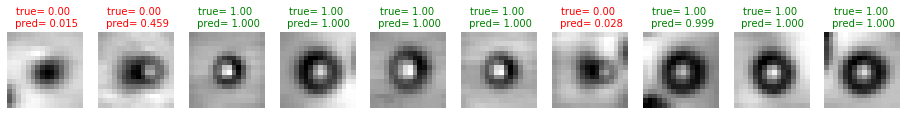

In [14]:
# A few correct labels at random
plot_test_with_title(rand_by_correct(True), "Correctly classified [random samples]")
save_name = f'Correctly classified_random.png'
plt.savefig(save_dir+save_name, bbox_inches='tight', dpi=200)
plt.show()
plt.close()

Best predicted bad CO-tips


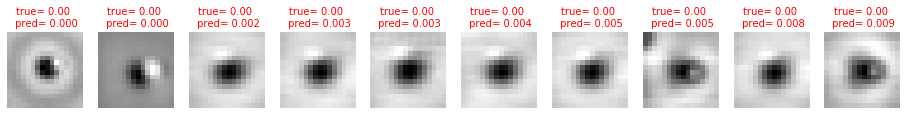

In [15]:
plot_test_with_title(most_by_correct(0, True), "Best predicted bad CO-tips")
save_name = f'best_predicted_bads.png'
plt.savefig(save_dir+save_name, bbox_inches='tight', dpi=200)
plt.show()
plt.close()

Best predicted good CO-tips


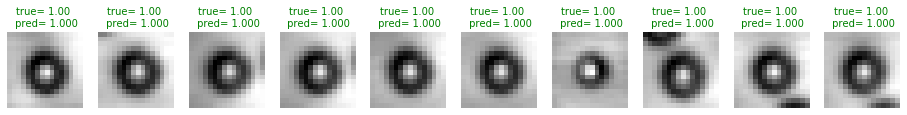

In [16]:
plot_test_with_title(most_by_correct(1, True), "Best predicted good CO-tips")
save_name = f'best_predicted_goods.png'
plt.savefig(save_dir+save_name, bbox_inches='tight', dpi=200)
plt.show()
plt.close()

Worst predicted bad CO-tips


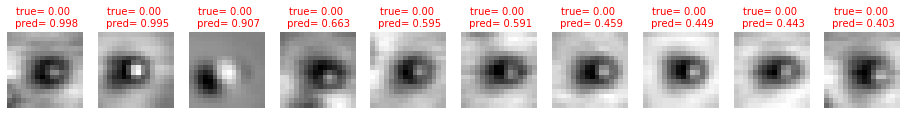

In [17]:
plot_test_with_title(worst_predicted(0), "Worst predicted bad CO-tips")
save_name = f'worst_predicted_bads.png'
plt.savefig(save_dir+save_name, bbox_inches='tight', dpi=200)
plt.show()
plt.close()

Worst predicted good CO-tips


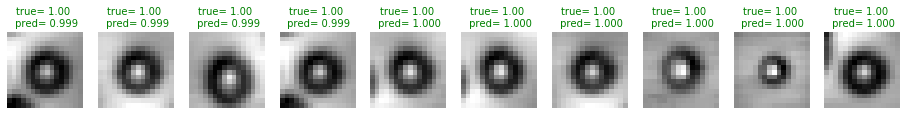

In [18]:
plot_test_with_title(worst_predicted(1),  "Worst predicted good CO-tips")
save_name = f'worst_predicted_goods.png'
plt.savefig(save_dir+save_name, bbox_inches='tight', dpi=200)
plt.show()
plt.close()

most_uncertain =  [33 32 15  1 31 19  6 21 23 24]
Most uncertain predictions


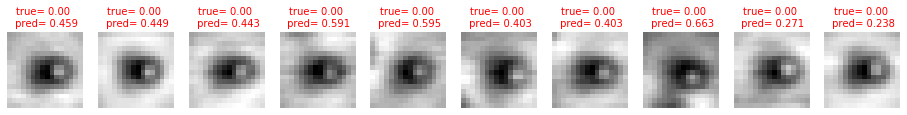

In [19]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:10]
print ('most_uncertain = ', most_uncertain)
plot_test_with_title(most_uncertain, "Most uncertain predictions")
save_name = f'most_uncertain.png'
plt.savefig(save_dir+save_name, bbox_inches='tight', dpi=200)
plt.show()
plt.close()

### Loss and accuracy at training

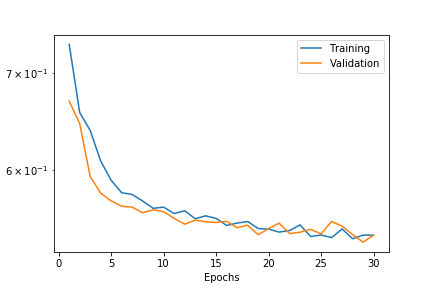

In [20]:
from IPython.display import Image
Image(save_dir+'/loss_history_class.png', height=300)

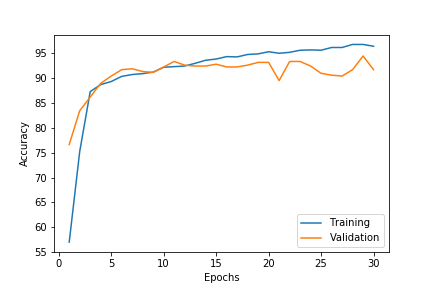

In [21]:
from IPython.display import Image
Image(save_dir+'/accu_history_class.png', height=300)

In [41]:
!conda env export > environment.yml